# Extract object distances from dataset

## Set up notebook

### Import libraries and set up paths

In [426]:
import os
import json
import pandas as pd
import numpy as np
import random
import scipy.io
import matplotlib.pyplot as plt
from scipy import ndimage
from gensim.models import KeyedVectors
import gensim.downloader as api
import seaborn as sns
from itertools import combinations
from nltk.corpus import wordnet as wn
from utils.utils import *
import time
from tqdm import tqdm

In [2]:
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir, 'data')
util_dir = os.path.join(proj_dir, 'utils')
analysis_dir = os.path.join(proj_dir, 'analysis')

### Read in data and models

In [3]:
# read dictionary mapping
with open(os.path.join(data_dir, 'namesToIds.json')) as json_file:
    namesToIds = json.load(json_file)
namesToIds['unlabeled'] = 0
idsToNames = {v: k for k, v in namesToIds.items()}

# read metadata
df = pd.read_csv('data/metadata.csv')
df['labels'] = df.labels.apply(eval)
df['instances'] = df.instances.apply(eval)

# import semantic embedding model
ft_300 = KeyedVectors.load(
    'models/fasttext-wiki-news-subwords-300.kv', mmap='r')

# get useful unique values for the possible names, scenes, and scene types
names = list(namesToIds.keys())
phrases = [name.split() for name in names]
scenes = sorted(df.scene.unique())
scene_types = sorted(df.scene_type.unique())
unwanted_labels = ['unknown', 'wall', 'ceiling', 'floor', 'door', 'window', 'person']

# read in image, depth, label, and instance images as memory maps
imgmat = np.memmap(os.path.join(data_dir, 'image_arr.npy'), dtype='uint8', mode='r', 
                   offset=128, shape=(1449,480,640,3))
depmat = np.memmap(os.path.join(data_dir, 'depth_arr.npy'), dtype='<f4', mode='r', 
                   offset=128, shape=(1449,480,640))
labmat = np.memmap(os.path.join(data_dir, 'label_arr.npy'), dtype='uint16', mode='r', 
                  offset=128, shape=(1449,480,640))
instmat = np.memmap(os.path.join(data_dir, 'instance_arr.npy'), dtype='uint8', mode='r', 
                  offset=128, shape=(1449,480,640))

### Post-hoc create full exemplar array

In [4]:
if not os.path.exists(os.path.join(data_dir, 'exemplar_arr.npy')):
    label_arr = np.load(os.path.join(data_dir, 'label_arr.npy'))
    instance_arr = np.load(os.path.join(data_dir, 'instance_arr.npy'))
    exemplar_arr = label_arr.astype(int) * 100 + instance_arr.astype(int) # labels in the 10000s, instances in the 10s
    np.save(os.path.join(data_dir, 'exemplar_arr.npy'), exemplar_arr)
else:
    exempmat = np.memmap(os.path.join(data_dir, 'exemplar_arr.npy'), dtype='int', mode='r', 
                         offset=128, shape=(1449,480,640))

## Extract object coordinates for a single image

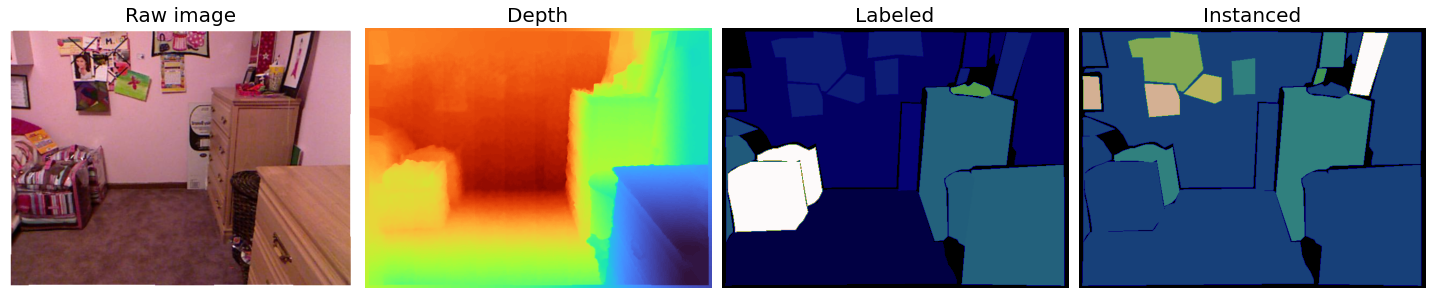

In [5]:
# show image
samp = 1046

fig, axs = plt.subplots(1,4, figsize=(20,6))

axs[0].imshow(imgmat[samp])
axs[1].imshow(depmat[samp], cmap='turbo')
axs[2].imshow(labmat[samp], cmap='gist_earth')
axs[3].imshow(instmat[samp], cmap='gist_earth')

[ax.axis('off') for ax in axs]
axs[0].set_title('Raw image', fontsize=20)
axs[1].set_title('Depth', fontsize=20)
axs[2].set_title('Labeled', fontsize=20)
axs[3].set_title('Instanced', fontsize=20)

fig.tight_layout()

In [416]:
depmat_df = pd.DataFrame(depmat[samp]).rename_axis('y').reset_index()\
                                      .melt(id_vars='y', var_name='x', value_name='depth')
exempmat_df = pd.DataFrame(exempmat[samp]).rename_axis('y').reset_index()\
                .melt(id_vars='y', var_name='x', value_name='exemplar')
exempmat_dict = exempmat_df.set_index(['x','y']).exemplar.to_dict()
depmat_df['exemplar'] = depmat_df.set_index(['x','y']).index.map(exempmat_dict)
depmat_df['label'] = (depmat_df.exemplar / 100).apply(np.floor).astype(int).map(idsToNames)
depmat_df['instance'] = depmat_df.exemplar.apply(lambda x: x % 100)

img_depth = depmat[samp].max() - depmat[samp].min()
img_height = img_depth
img_width = 640 / 480 * img_height

depmat_df['x_dist'] = depmat_df.x / 640 * img_width
depmat_df['y_dist'] = depmat_df.y / 480 * img_height

locs = []
for i in np.unique(exempmat[samp]):
    if i == 0:
        continue
    exemp_df = depmat_df[depmat_df.exemplar == i].reset_index(drop=True)
    means = np.array([exemp_df.x_dist.mean(), exemp_df.y_dist.mean(), exemp_df.depth.mean()])
    arr = (exemp_df[['x_dist', 'y_dist', 'depth']] - means).values
    exemp_df['opts'] = np.sum(arr ** 2, axis=1) ** (1./2)
    exemp_df['opts'] = exemp_df['opts'].astype(float)
    exemp_df['image_index'] = samp
    locs.append(exemp_df.iloc[exemp_df.opts.idxmin()].drop('opts').to_dict())
    
locs = pd.DataFrame(locs)

### outcome of location extraction on image

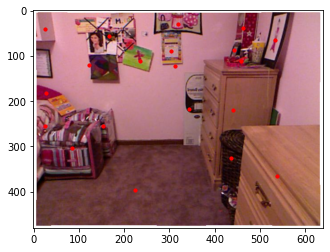

In [423]:
plt.imshow(imgmat[samp])
plt.scatter(locs.x, locs.y, c='red', s=10)

## Extract object locations for all images

In [433]:
object_locs = []
for img in tqdm(range(depmat.shape[0])):
    depmat_df = pd.DataFrame(depmat[img]).rename_axis('y').reset_index()\
                                      .melt(id_vars='y', var_name='x', value_name='depth')
    exempmat_df = pd.DataFrame(exempmat[img]).rename_axis('y').reset_index()\
                    .melt(id_vars='y', var_name='x', value_name='exemplar')
    exempmat_dict = exempmat_df.set_index(['x','y']).exemplar.to_dict()
    depmat_df['exemplar'] = depmat_df.set_index(['x','y']).index.map(exempmat_dict)
    depmat_df['label'] = (depmat_df.exemplar / 100).apply(np.floor).astype(int).map(idsToNames)
    depmat_df['instance'] = depmat_df.exemplar.apply(lambda x: x % 100)

    img_depth = depmat[img].max() - depmat[img].min()
    img_height = img_depth
    img_width = 640 / 480 * img_height

    depmat_df['x_dist'] = depmat_df.x / 640 * img_width
    depmat_df['y_dist'] = depmat_df.y / 480 * img_height

    for i in np.unique(exempmat[img]):
        if i == 0:
            continue
        exemp_df = depmat_df[depmat_df.exemplar == i].reset_index(drop=True)
        means = np.array([exemp_df.x_dist.mean(), exemp_df.y_dist.mean(), exemp_df.depth.mean()])
        arr = (exemp_df[['x_dist', 'y_dist', 'depth']] - means).values
        exemp_df['opts'] = np.sum(arr ** 2, axis=1) ** (1./2)
        exemp_df['opts'] = exemp_df['opts'].astype(float)
        exemp_df['image_index'] = img
        object_locs.append(exemp_df.iloc[exemp_df.opts.idxmin()].drop('opts').to_dict())
object_df = pd.DataFrame(object_locs)

100%|████████████████████████████████████████████████████████████████████████████| 1449/1449 [1:59:10<00:00,  4.93s/it]


In [439]:
if not os.path.exists(os.path.join(data_dir, 'spatial_exemplars.csv')):
    object_df.to_csv(os.path.join(data_dir, 'spatial_exemplars.csv'), index=False)
else:
    object_df = pd.read_csv(os.path.join(data_dir, 'spatial_exemplars.csv'))

### Plot final results for a random image

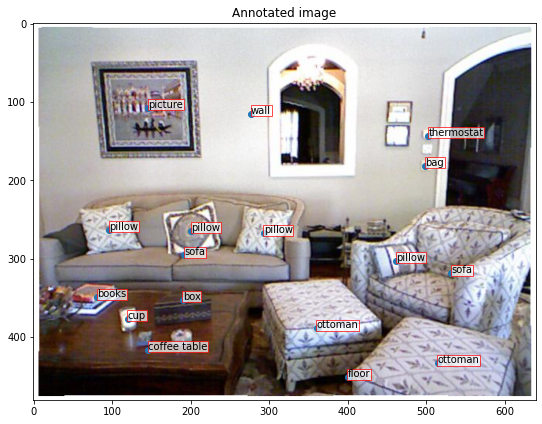

In [575]:
# sample an image
samp = np.random.randint(0, imgmat.shape[0]+1)
samp_locs = object_df[object_df.image_index == samp]

# plot annotated labels on top of image
fig, ax = plt.subplots(figsize=(9,12))
ax.imshow(imgmat[samp])
for idx, row in samp_locs.iterrows():
    ax.annotate(row.label, (row.x, row.y),
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=0.5))
ax.scatter(samp_locs.x, samp_locs.y)
ax.set_title('Annotated image')
plt.show()

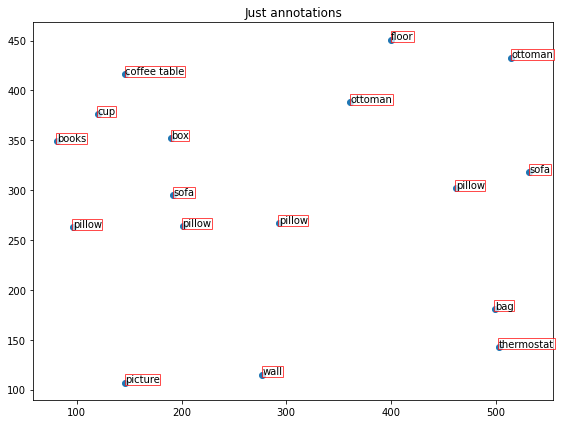

In [576]:
# show just the annotations
fig, ax = plt.subplots(figsize=(8,6))
for idx, row in samp_locs.iterrows():
    ax.annotate(row.label, (row.x, row.y),
                bbox=dict(facecolor='white', edgecolor='red', alpha=0.7, pad=0.5))
ax.scatter(samp_locs.x, samp_locs.y)
ax.set_title('Just annotations')
plt.tight_layout()
plt.show()